### Data Analysis
#### Table of Content
1. [Data Overview](#1-data-overview)
1. [Impact of mapping on Latency](#2-impact-of-mapping-on-latency)

In [1]:
# directory_path = 'data/task_5'
# directory_path = 'data/task_10'
directory_path = 'data/task_7'

import os 
import pickle 

entries = os.listdir(directory_path)
files = sorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

list_of_dict = []
for file_name in files: 
    file_path = os.path.join(directory_path,file_name)
    with open(file_path, 'rb') as file: 
        dict = pickle.load(file)
        list_of_dict.append(dict)
        
print(f"Number of files in \"{directory_path}\": \t{len(files)}")
print(f"Number of files in imported list: \t{len(list_of_dict)}")

Number of files in "data/task_7": 	120000
Number of files in imported list: 	120000


In [2]:
"""
Converting Imported data to Pandas.DataFrame
"""
import pandas as pd 
data_df = pd.DataFrame(list_of_dict)


#### 1. Data overview 

In [3]:

pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("\n\t\t\tProcessing Time Summary")
print(data_df['processing_time'].describe())

print("\n\t\t\tFlit Latency (avg) Summary")
print(data_df['avg_flit_lat'].describe())

print("\n\t\t\tPacket Latency (avg) Summary")
print(data_df['avg_packet_lat'].describe())

print("\n\t\t\tNetwork Latency (avg) Summary")
print(data_df['avg_network_lat'].describe())

pd.set_option('display.float_format', None)


			Processing Time Summary
count   120000.000
mean      6989.548
std       4210.103
min        582.000
25%       3209.000
50%       6114.000
75%      10148.000
max      17380.000
Name: processing_time, dtype: float64

			Flit Latency (avg) Summary
count   120000.000
mean        15.191
std          8.287
min          6.161
25%         10.554
50%         12.452
75%         16.139
max         92.768
Name: avg_flit_lat, dtype: float64

			Packet Latency (avg) Summary
count   120000.000
mean        57.125
std         25.879
min         38.013
25%         42.584
50%         45.019
75%         61.337
max        232.588
Name: avg_packet_lat, dtype: float64

			Network Latency (avg) Summary
count   120000.000
mean        57.125
std         25.879
min         38.013
25%         42.584
50%         45.019
75%         61.337
max        232.588
Name: avg_network_lat, dtype: float64


In [4]:
import numpy as np

all_demand = np.array([demand[0] for demand_list in list(data_df['demand']) for demand in demand_list])
print(f"For Demand, Max: {np.max(all_demand)}, Min: {np.min(all_demand)}")

all_duration = np.array([np.array(item) for item in data_df['duration']], dtype=float)
print(f"For Delay, Max: {np.max(all_duration)}, Min: {np.min(all_duration)}")

For Demand, Max: 99.94349008949725, Min: 1.0197634845348942
For Delay, Max: 99.96484196603967, Min: 1.0276906297344022


In [5]:
import matplotlib.pyplot as plt

"""
Get Latency Distribution from the number of mapping each task has.
    Given Parameters of the DAG and the demand level, this code will fetch all the mapping and then returns the stats for analysis.
"""

def calculateStats(dataframe, column_names):
    stats_dict = {}
    for column_name in column_names:
        column_range = dataframe[column_name].max() - dataframe[column_name].min()
        column_std_dev = dataframe[column_name].std()
        column_mean = dataframe[column_name].mean()
        column_median = dataframe[column_name].median()
        column_max = dataframe[column_name].max()
        column_min = dataframe[column_name].min()
        
        stats_dict[column_name] = {
            'range': column_range,
            'std': column_std_dev, 
            'mean': column_mean, 
            'median': column_median, 
            'min' : column_min,
            'max' : column_max
        }
    return stats_dict

def plotDualAxis(x, x_label, title, y1, y1_label, y2,  y2_label, log_scale=False):
        fig, ax1 = plt.subplots(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches

        ax1.plot(x, y1, label=y1_label, color='gold')
        if log_scale:
            ax1.set_yscale('log')  # Set log scale for the y-axis on the left
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y1_label )
        ax1.tick_params('y' )

        ax2 = ax1.twinx()

        ax2.plot(x, y2, label=y2_label, color='cadetblue')
        if log_scale:
            ax2.set_yscale('log')  # Set log scale for the y-axis on the left
        ax2.set_ylabel(y2_label)
        ax2.tick_params('y')

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.title(title)
        # ax1.grid(True, linestyle='--', alpha=0.7)
        # ax2.grid(True, linestyle='--', alpha=0.7)

        fig.tight_layout()
        plt.show()

def getStatFromFilteredDF(demand_df):
    demand_df.reset_index(inplace=True, drop=True)
    demand_df.index += 1

    stats = calculateStats(demand_df, ['avg_packet_lat', 'avg_flit_lat', 'avg_network_lat', 'processing_time'])
    return stats

def getMapVariation(data_df,max_out, alpha, beta, demand_level=None):
    filtered_df = data_df.query(f"max_out == {max_out} and alpha == {alpha} and beta == {beta} and demand_level == {demand_level}")
    unique_demand = filtered_df['demand'].apply(tuple).unique() # Returns Unique values of Demand

    unique_lists = [list(t) for t in unique_demand] # List of Unique demand values
    
    stat_list = []
    for unique_list in unique_lists:
        demand_df = filtered_df[filtered_df['demand'].apply(lambda x: set(unique_list).issubset(set(x)))] # Filtering dataframe by looking for similar demand
        stat = getStatFromFilteredDF(demand_df)
        stat_list.append(stat)

    return stat_list

max_out_list = sorted(data_df['max_out'].unique())
alpha_list = sorted(data_df['alpha'].unique())
beta_list = sorted(data_df['beta'].unique())
demand_level_list = sorted(data_df['demand_level'].unique())

print(f"Max Out: \t{max_out_list}")
print(f"Alpha: \t\t{alpha_list}")
print(f"Beta: \t\t{beta_list}")
print(f"Demand Level: \t{demand_level_list}")

mapping_data = []
import copy 
for max_out in max_out_list:
    for alpha in alpha_list:
        for beta in beta_list:
            for demand_level in demand_level_list:
                param = {}
                stat_list = getMapVariation(data_df, max_out, alpha, beta, demand_level) # Returns a list with demandCount size [{avg_packet_lat, avg_flit_lat}, {avg_packet_lat, avg_flit_lat}]
                param['max_out'] = max_out
                param['alpha'] = alpha
                param['beta'] = beta
                param['demand_level'] = demand_level

                for demand_stat in stat_list: # Looping through Demand Counts
                    stat = {}
                    for feature_name in demand_stat: # avg_packet_lat or avg_flit_lat
                        for stat_name in demand_stat[feature_name]: # Range, Std, mean, median, min, max
                            name = feature_name + '_' + stat_name
                            stat[name] = demand_stat[feature_name][stat_name]

                    param = {**param, **stat} # Have to use unpacking operator, otherwise (using update) it creates a reference.? 
                    mapping_data.append(param)


print(f"\nLength of mapping Data {len(mapping_data)}")
mapping_data_df = pd.DataFrame(mapping_data)

Max Out: 	[1, 2, 3, 4, 5]
Alpha: 		[0.5, 1.0, 1.5]
Beta: 		[0.0, 0.5, 1.0, 2.0]
Demand Level: 	[0]

Length of mapping Data 120


#### 2. Impact of mapping on Latency 

In the data-generation process, each time a task graph is created, we perform multiple random mappings (specifically, 10 different mappings) for the same task. In this section, we explore the impact of these random mappings on packet latency. The presented graph clearly illustrates that latency is influenced by the chosen mapping strategies.

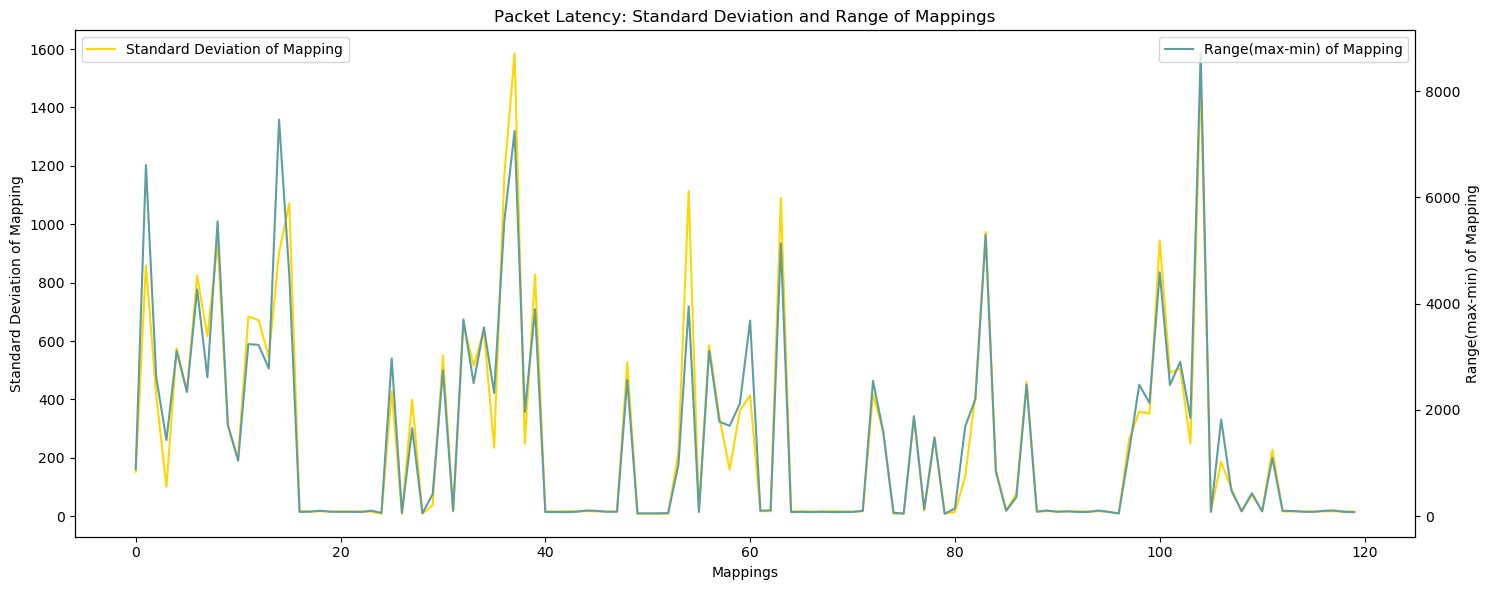

count     120.000000
mean      259.460837
std       350.157270
min         8.859463
25%        16.754132
50%        19.551110
75%       416.773732
max      1585.123951
Name: processing_time_std, dtype: float64
count     120.000000
mean     1439.275000
std      1873.227166
min        48.000000
25%        83.000000
50%       138.500000
75%      2473.000000
max      8710.000000
Name: processing_time_range, dtype: float64


In [9]:
"""
Plot Mapping Data
"""

plotDualAxis(mapping_data_df.index.to_numpy(), 'Mappings', 'Packet Latency: Standard Deviation and Range of Mappings', 
             mapping_data_df['processing_time_std'].to_numpy(), 'Standard Deviation of Mapping', 
             mapping_data_df['processing_time_range'].to_numpy(), 'Range(max-min) of Mapping', )

print(mapping_data_df['processing_time_std'].describe())
print(mapping_data_df['processing_time_range'].describe())

#### 3. Task Shape for same parameters

When same DAG parameters are used to generate a TASK graph, we get slightly different architectures with some degree of similarity. 

For a given task DAG. Mapping is completely different for the same task.

Number of elemnts in DataFrame: 1000


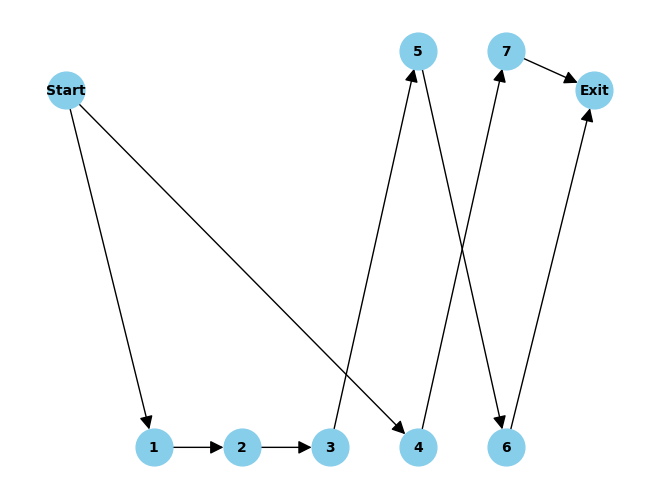

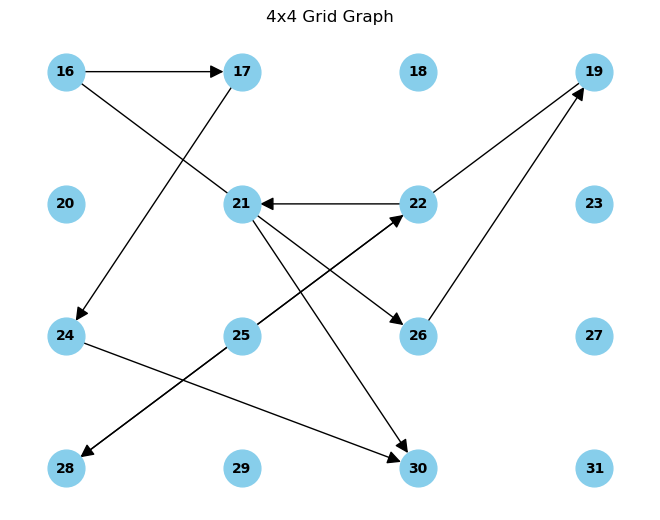

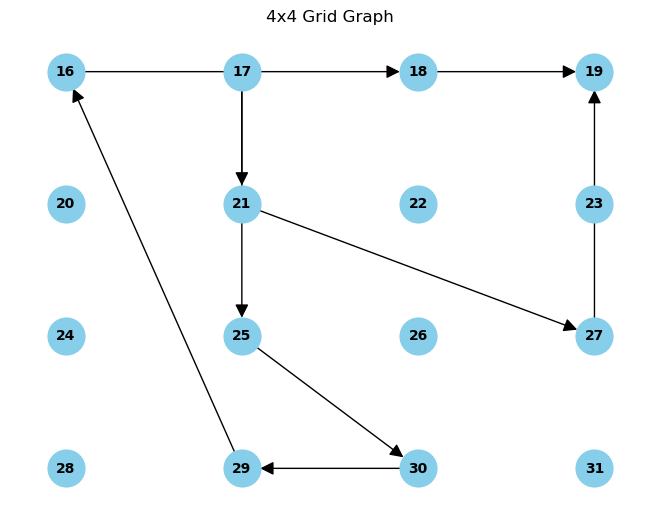

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

filtered_parameter_df = data_df.query(f"max_out == {1} and alpha == {0.5} and beta == {0.0} and demand_level == {0}")
filtered_parameter_df.reset_index(inplace=True, drop=True)

print(f"Number of elemnts in DataFrame: {filtered_parameter_df.count()[0]}")

from gcn.utils import visGraph, visGraphGrid, net_4x4

def displayGraph(index, task=False):
    if task: graph_string = 'task'
    else: graph_string = 'map'
    graph = filtered_parameter_df.loc[index, str(graph_string) + '_graph']
    pos = filtered_parameter_df.loc[index, str(graph_string) + '_graph_pos']
    visGraph(graph, pos=pos)

index = 4
displayGraph(index,task=True)
graph = filtered_parameter_df.loc[index, 'map_graph']
visGraphGrid(graph.edges, net_4x4)

index = 5
graph = filtered_parameter_df.loc[index, 'map_graph']
visGraphGrid(graph.edges, net_4x4)

### To Do: Representation of Machine learning Model

[0, 91.86786628926919, 22.331521011139067, 70.62473224772619, 6.301961532507095, 66.68079336425807, 42.85728796860603, 99.49249899669412, 0]
[0, 4.110594675185045, 41.766711075453856, 64.09964231258027, 28.966864838621206, 45.459163693353716, 45.03344336154662, 46.65998529515863, 0]
Processing Time is 13352.0


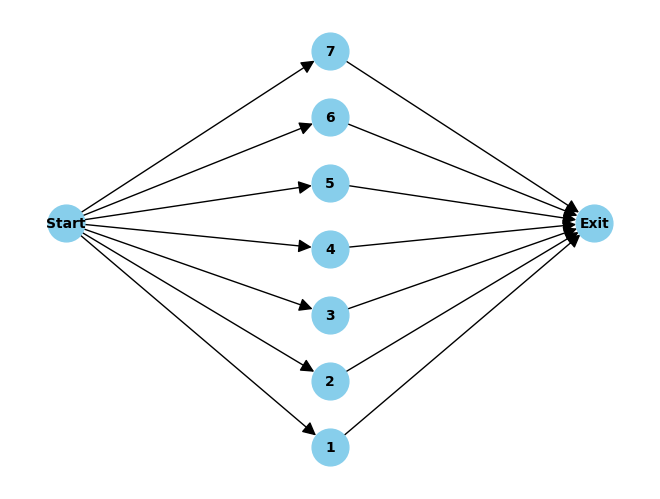

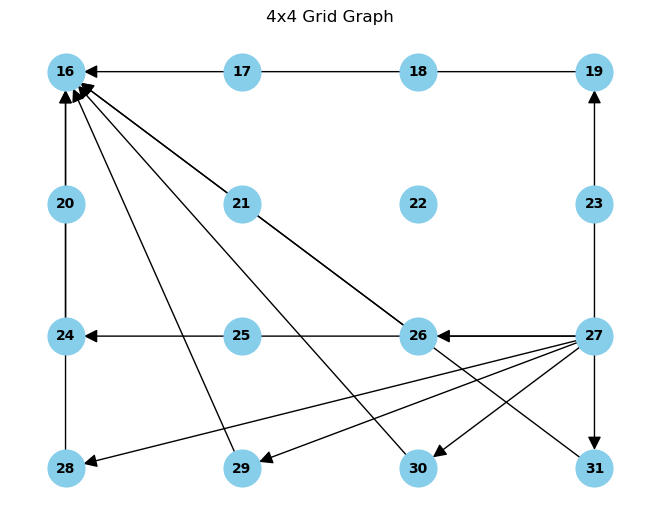

In [8]:

task = list_of_dict[1000]
task_graph = task['task_graph']

map_graph = task['map_graph']
task_demands = [demands[0] for demands in task['demand']]
task_demands.insert(0,0)
task_demands.append(0)
task_duration = task['duration']
task_duration.insert(0,0)
task_duration.append(0)
task_processing_time = task['processing_time']

print(task_demands)
print(task_duration)
print(f"Processing Time is {task['processing_time']}")

visGraph(task_graph, pos=task['task_graph_pos'])
visGraphGrid(map_graph.edges, net_4x4)